## Initial Preparation/Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import random
import sys
import joblib
from time import time
import pickle
#Append hardcore path of feature_format module python file
sys.path.append("C:/Users/karun/Documents/Finale_ Python/Enron corpus fraud analysis/feature_format.py/")
from feature_format import *
#Append hardcore path of tester module python file
sys.path.append("C:/Users/karun/Documents/Finale_ Python/Enron corpus fraud analysis/tester.py/")
from tester import *
#from outlier_cleaner import *
import logging
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from nltk.stem.snowball import SnowballStemmer
import string
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
import base64
import json
import subprocess
import pprint
import warnings
warnings.filterwarnings('ignore')

## Create Features list and Import necessary files

In [2]:
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person',
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
#Append hardcore path of the dataset file
data_dict = joblib.load( open("C:/Users/karun/Documents/Finale_ Python/Enron corpus fraud analysis/final_project_dataset.pkl", "rb") )

## Initial data exploration

In [3]:
#Sample data for one of the Top executives - Jeffrey Skilling
pprint.pprint(data_dict["SKILLING JEFFREY K"])

#Number of people in the datasets

print("Total number of people in the dataset: " + str(len(data_dict)))

#Number of features available in the dataset

print("Total number of features in the dataset: " + str(len(data_dict["SKILLING JEFFREY K"])))

#Number of POIs in the dataset

def poi_count(file):
    count = 0
    for data in file:
        if file[data]['poi'] == True:
            count += 1
    print("Number of POIs in the dataset: " + str(count))

poi_count(data_dict)

{'bonus': 5600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeff.skilling@enron.com',
 'exercised_stock_options': 19250000,
 'expenses': 29336,
 'from_messages': 108,
 'from_poi_to_this_person': 88,
 'from_this_person_to_poi': 30,
 'loan_advances': 'NaN',
 'long_term_incentive': 1920000,
 'other': 22122,
 'poi': True,
 'restricted_stock': 6843672,
 'restricted_stock_deferred': 'NaN',
 'salary': 1111258,
 'shared_receipt_with_poi': 2042,
 'to_messages': 3627,
 'total_payments': 8682716,
 'total_stock_value': 26093672}
Total number of people in the dataset: 146
Total number of features in the dataset: 21
Number of POIs in the dataset: 18


## Detect outliers and remove them

97343619.0


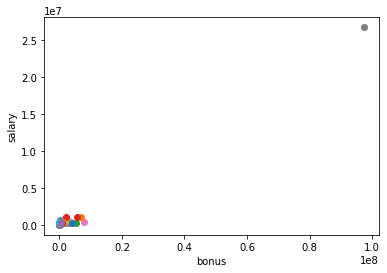

In [4]:
features = ["bonus","salary"]
data = featureFormat(data_dict, features)
print(data.max())

for point in data:
    bonus = point[0]
    salary = point[1]
    plt.scatter( bonus, salary )

plt.xlabel("bonus")
plt.ylabel("salary")
plt.show()

## Maximum Salary

In [5]:
outliers_salary = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers_salary.append((key,int(val)))

pprint.pprint(sorted(outliers_salary,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 26704229), ('SKILLING JEFFREY K', 1111258)]


## Removing Total and Travel Agency in the Park outliers

In [6]:
data_dict.pop('TOTAL',0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)

{'salary': 'NaN',
 'to_messages': 'NaN',
 'deferral_payments': 'NaN',
 'total_payments': 362096,
 'loan_advances': 'NaN',
 'bonus': 'NaN',
 'email_address': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'deferred_income': 'NaN',
 'total_stock_value': 'NaN',
 'expenses': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 'NaN',
 'from_messages': 'NaN',
 'other': 362096,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 'NaN',
 'director_fees': 'NaN'}

## Plotting after outlier removal

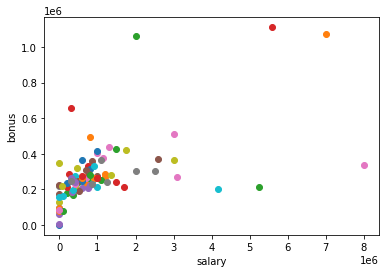

In [7]:
my_dataset = data_dict
my_feature_list = features_list
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )


plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

## Investigating emails from and to a Person of Interest

609.0


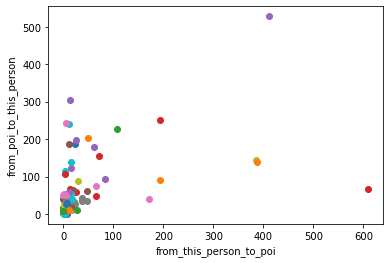

In [8]:
features = ["from_this_person_to_poi", "from_poi_to_this_person"]
data = featureFormat(data_dict, features)

print(data.max())
#Plotting the graph
for point in data:
    from_this_person_to_poi = point[0]
    from_poi_to_this_person = point[1]
    plt.scatter( from_this_person_to_poi, from_poi_to_this_person )

plt.xlabel("from_this_person_to_poi")
plt.ylabel("from_poi_to_this_person")
plt.show()

## Dealing with 'NaN' values

In [9]:
df_values = pd.DataFrame.from_records(list(data_dict.values()))
df_values.head()

df_persons = pd.Series(list(data_dict.keys()))
df_persons.head()

#We see lot's of NaN values. So we have to take care of that. We will convert them to numpy nan and then to zero.
df_values.replace(to_replace='NaN', value=np.nan, inplace=True)

# Count number of NaN's for columns
print(df_values.isnull().sum())

# DataFrame dimension
print(df_values.shape)


df_null = df_values.replace(to_replace=np.nan, value=0)
df_null = df_values.fillna(0).copy(deep=True)
df_null.columns = list(df_values.columns.values)
print(df_null.isnull().sum())
print(df_null.head())

df_null.describe()

salary                        50
to_messages                   58
deferral_payments            106
total_payments                21
loan_advances                141
bonus                         63
email_address                 33
restricted_stock_deferred    127
deferred_income               96
total_stock_value             19
expenses                      50
from_poi_to_this_person       58
exercised_stock_options       43
from_messages                 58
other                         53
from_this_person_to_poi       58
poi                            0
long_term_incentive           79
shared_receipt_with_poi       58
restricted_stock              35
director_fees                128
dtype: int64
(144, 21)
salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
email_address                0
restricted_stock_deferred    0
deferred_income              0
total

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.440000e+02,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,144.000000,1.440000e+02,144.000000,1.440000e+02,144.000000,1.440000e+02,144.000000
mean,1.854460e+05,1238.555556,2.220896e+05,2.256543e+06,5.828125e+05,6.759974e+05,7.341790e+04,-1.936833e+05,2.909786e+06,35375.340278,38.756944,2.075802e+06,363.583333,2.947455e+05,24.625000,3.369578e+05,702.611111,8.685363e+05,9980.319444
std,1.970421e+05,2237.564816,7.541013e+05,8.847189e+06,6.794472e+06,1.233155e+06,1.301983e+06,6.060111e+05,6.189018e+06,45309.303038,74.276769,4.795513e+06,1450.675239,1.131325e+06,79.778266,6.871826e+05,1077.290736,2.016572e+06,31300.575144
min,0.000000e+00,0.000000,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-1.787380e+06,-3.504386e+06,-4.409300e+04,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-2.604490e+06,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,9.019275e+04,0.000000e+00,0.000000e+00,0.000000e+00,-3.708600e+04,2.443265e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.434500e+04,0.000000
50%,2.105960e+05,347.500000,0.000000e+00,9.413595e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000e+00,9.659550e+05,20182.000000,4.000000,6.082935e+05,17.500000,9.190000e+02,0.000000,0.000000e+00,114.000000,3.605280e+05,0.000000
75%,2.696675e+05,1623.000000,8.535500e+03,1.945668e+06,0.000000e+00,8.000000e+05,0.000000e+00,0.000000e+00,2.295176e+06,53328.250000,41.250000,1.683580e+06,53.000000,1.485770e+05,14.000000,3.745862e+05,933.750000,7.374560e+05,0.000000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,8.152500e+07,8.000000e+06,1.545629e+07,0.000000e+00,4.911008e+07,228763.000000,528.000000,3.434838e+07,14368.000000,1.035973e+07,609.000000,5.145434e+06,5521.000000,1.476169e+07,137864.000000


## Classifier's Result before Feature Engineering

In [10]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
features_train,features_test,labels_train,labels_test = model_selection.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=21)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

Decision Tree Classifier: 
Accuracy: 0.7441860465116279
Precision Score: 0.2222222222222222
Recall Score: 0.3333333333333333


## Feature Engineering

In [11]:
def add_poi_ratio(data_dict, features_list):
    """ mutates data dict to add proportion of email interaction with pois """
    fields = ['to_messages', 'from_messages',
              'from_poi_to_this_person', 'from_this_person_to_poi']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['to_messages'] +\
                             person['from_messages']
            poi_messages = person['from_poi_to_this_person'] +\
                           person['from_this_person_to_poi']
            person['poi_ratio'] = float(poi_messages) / total_messages
        else:
            person['poi_ratio'] = 'NaN'
    features_list += ['poi_ratio']



def add_fraction_to_poi(data_dict, features_list):
    """ mutates data dict to add proportion of email fraction_to_poi """
    fields = ['from_messages', 'from_this_person_to_poi']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['from_messages']
            poi_messages =   person['from_this_person_to_poi']
            person['fraction_to_poi'] = float(poi_messages) / total_messages
        else:
            person['fraction_to_poi'] = 'NaN'
    features_list += ['fraction_to_poi']


def add_fraction_from_poi(data_dict, features_list):
    """ mutates data dict to add proportion of email fraction_from_poi """
    fields = ['to_messages', 'from_poi_to_this_person']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['to_messages']
            poi_messages =   person['from_poi_to_this_person']
            person['fraction_from_poi'] = float(poi_messages) / total_messages
        else:
            person['fraction_from_poi'] = 'NaN'
    features_list += ['fraction_from_poi']



#Adding them to the features list
add_poi_ratio(data_dict, my_feature_list)
add_fraction_to_poi(data_dict, my_feature_list)
add_fraction_from_poi(data_dict, my_feature_list)
print(my_feature_list)

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']


## Classifier's Result after Feature Engineering

In [12]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
features_train,features_test,labels_train,labels_test = model_selection.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=21)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

Decision Tree Classifier: 
Accuracy: 0.7441860465116279
Precision Score: 0.14285714285714285
Recall Score: 0.16666666666666666


In [13]:
def get_k_best(enron_data, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print("{0} best features: {1}\n".format(k, k_best_features.keys()))
    print(k_best_features)
    return k_best_features

target_label = 'poi'
num_features = 7 # 11 best features
top_features = get_k_best(data_dict, features_list, num_features)
print(top_features)
my_feature_list = [target_label] + list(top_features.keys())
# print my_feature_list

print("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

features_list = my_feature_list

7 best features: dict_keys(['exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'long_term_incentive'])

{'exercised_stock_options': 24.815079733218194, 'total_stock_value': 24.18289867856688, 'bonus': 20.792252047181535, 'salary': 18.289684043404513, 'fraction_to_poi': 16.409712548035788, 'deferred_income': 11.458476579280369, 'long_term_incentive': 9.922186013189823}
{'exercised_stock_options': 24.815079733218194, 'total_stock_value': 24.18289867856688, 'bonus': 20.792252047181535, 'salary': 18.289684043404513, 'fraction_to_poi': 16.409712548035788, 'deferred_income': 11.458476579280369, 'long_term_incentive': 9.922186013189823}
7 selected features: ['exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'long_term_incentive']



## Validity of SelectKBest

In [14]:
features_list = ["poi", "fraction_from_poi", "fraction_to_poi", "shared_receipt_with_poi"]

## Extract features and labels from dataset for local testing

In [15]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Scaling the features by MinMaxScaler from Sklearn preprocessing module

In [16]:
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

## Splitting the data into train data(70%) and test data(30%)

In [17]:
features_train,features_test,labels_train,labels_test = model_selection.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=21)

# Using different Machine Learning Classifiers

## Decision Tree Classifier

In [18]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

Decision Tree Classifier: 
Accuracy: 0.8461538461538461
Precision Score: 0.6666666666666666
Recall Score: 0.6666666666666666


## Naive Bayes Classifier

In [19]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Naive Bayes Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

Naive Bayes Classifier: 
Accuracy: 0.6923076923076923
Precision Score: 0.25
Recall Score: 0.16666666666666666


## AdaBoost Classifier

In [20]:
clf = AdaBoostClassifier()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Adaboost Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

Adaboost Classifier: 
Accuracy: 0.8076923076923077
Precision Score: 0.5714285714285714
Recall Score: 0.6666666666666666


## Standard Vector Machine (rbf) Classifier

In [21]:
clf = SVC(gamma=3, C=2)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("SVM Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

SVM Classifier: 
Accuracy: 0.7692307692307693
Precision Score: 0.0
Recall Score: 0.0


## K Nearest Neighbours Classifier

In [22]:
clf = KNeighborsClassifier(3)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("kNN Classifier: ")
print("Accuracy: " + str(accuracy))
print("Precision Score: " + str(precision_score(labels_test,pred)))
print("Recall Score: " + str(recall_score(labels_test,pred)))

kNN Classifier: 
Accuracy: 0.7692307692307693
Precision Score: 0.5
Recall Score: 0.16666666666666666


### Precision, recall and F1 

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
cv = model_selection.StratifiedShuffleSplit(n_splits=2,test_size=0.3,random_state=21)


def scoring(estimator, features_test, labels_test):
    labels_pred = estimator.predict(features_test)
    p = precision_score(labels_test, labels_pred, average='micro')
    r = recall_score(labels_test, labels_pred, average='micro')
    if p > 0.3 and r > 0.3:
        return f1_score(labels_test, labels_pred, average='macro')
    return 0

## Recursive Feature Selection

Optimal number of features : 3
[ True  True  True]


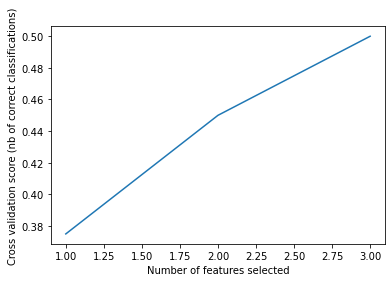

In [24]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
clf = DecisionTreeClassifier(max_depth = 5)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(n_splits=2, random_state=None),
          scoring='precision')
rfecv.fit(features, labels)
print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.support_)
features=features[:,rfecv.support_]
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Decision Tree Classifier Tuning

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from time import time
from sklearn.metrics import f1_score
from sklearn import tree
t0 = time()
parameters = { 'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10], 
               'min_samples_split':[2,3,4,5,6,7,8,9,10],
               'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
               'criterion': ('gini', 'entropy')
             }
decTree_clf = DecisionTreeClassifier()
decTreeclf = GridSearchCV(decTree_clf, parameters, scoring=scoring , cv=cv)

decTreeclf.fit(features, labels)
print(decTreeclf.best_estimator_)
print(decTreeclf.best_score_)
print('Processing time:', round(time() - t0, 3), 's')

DecisionTreeClassifier(max_depth=3, min_samples_leaf=7)
0.6231884057971014
Processing time: 8.012 s


In [26]:
import pickle
import sys
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit
#Append hardcore path of feature_format module python file
sys.path.append("C:/Users/karun/Documents/Finale_ Python/Enron corpus fraud analysis/tester.py/")
from feature_format import *
PERF_FORMAT_STRING = "\\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds=1000):
    data = featureFormat(dataset, feature_list, sort_keys=True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(n_splits=folds, random_state=42)
    true_negatives  = 0
    false_negatives = 0
    true_positives  = 0
    false_positives = 0
    for train_idx, test_idx in cv.split(features, labels):
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append(features[ii])
            labels_train.append(labels[ii])
        for jj in test_idx:
            features_test.append(features[jj])
            labels_test.append(labels[jj])

        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print("Warning: Found a predicted label not == 0 or 1.")
                print("All predictions should take value 0 or 1.")
                print("Evaluating performance for processed predictions:")
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print(clf)
        print(PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print(RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives))
        print("")
    except:
        print("Got a divide by zero when trying out:", clf)

## Classifier Validation

In [27]:
from time import time
t0 = time()
decTree_best_clf = decTreeclf.best_estimator_
test_classifier(decTree_best_clf, my_dataset, features_list)
print('Processing time:', round(time() - t0, 3), 's')

DecisionTreeClassifier(max_depth=3, min_samples_leaf=7)
\tAccuracy: 0.88489	Precision: 0.48387	Recall: 0.54000	F1: 0.51040	F2: 0.52776
	Total predictions: 9000	True positives:  540	False positives:  576	False negatives:  460	True negatives: 7424

Processing time: 0.595 s


In [28]:
from time import time
from sklearn.model_selection import cross_val_score
t0 = time()
decTree_best_clf = decTreeclf.best_estimator_
scores = cross_val_score(decTree_best_clf, features, labels, cv=cv,scoring = 'accuracy')
print("Accuracy and Deviation: " + str((scores.mean(), scores.std() * 2)))
print('Processing time:', round(time() - t0, 3), 's')
test_classifier(decTree_best_clf, my_dataset, features_list)

Accuracy and Deviation: (0.8461538461538461, 0.0)
Processing time: 0.008 s
DecisionTreeClassifier(max_depth=3, min_samples_leaf=7)
\tAccuracy: 0.88422	Precision: 0.48118	Recall: 0.53700	F1: 0.50756	F2: 0.52482
	Total predictions: 9000	True positives:  537	False positives:  579	False negatives:  463	True negatives: 7421

